In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import analyze # takes some time since inits hax
from channel_dict import channel_dict
from tqdm import tqdm
import datetime

%matplotlib inline

### Job Submission

In [ ]:
#job submission

#dry run
from make_runlist_new import write_spe_lists

write_spe_lists(write=False)

In [ ]:
#writes actual runlists

written=write_spe_lists(write=True)

In [ ]:
def submit_job(file):
    command = "./submit_jobs.sh %s" % os.path.join('runlists', file)
    print(command)
    !{command}

In [ ]:
#submit jobs for new runlists
for f in written:
    submit_job(f)

### Acc vs Time Plot

In [2]:
ACTUALLY_OFF = [1, 2, 12, 26, 34, 62, 65, 79, 86, 88, 102, 118, 
                130, 134, 135, 139, 148, 150, 152, 162, 178, 183,
                190, 198, 206, 213, 214, 234, 239, 244]

In [ ]:
import hax
#hax already initiated when analyze is imported

from spe_acceptance import data_dir_base


def data_exists(run_number):
    data_path=os.path.join(data_dir_base, 'run_%05d.h5' %run_number)
    return os.path.exists(data_path)

def all_data_exists(runlist):
    return all([data_exists(run) for run in runlist])

def file_to_list(runlist_file):
    return [int(run) for run in runlist_file.split('.')[0].split('_')[1:4]]

def get_run_time(run):
    return hax.runs.datasets[hax.runs.datasets.number == run].start.values[0]

In [ ]:
runlists = [f for f in os.listdir('./runlists')]

bottom_runs = []
accs = []
errors = []

missing_runs = []
LED_off = []
resubmit_files = []

for f in tqdm(sorted(runlists)):
    runlist = file_to_list(f)
    if not all_data_exists(runlist):
        resubmit_files.append(f)
        #print('data missing for %s' % f)
        for r in runlist:
            if not data_exists(r):
                missing_runs.append(r)
        continue
        
    bottom_run = runlist[0]
    topbulk_run = runlist[1]
    topring_run = runlist[2]
    
    thresholds = analyze.get_thresholds(analyze.find_regular_run(bottom_run))
    
    acc, acc_errs = analyze.acceptance_3runs(bottom_run, topbulk_run, topring_run, thresholds)
    occ, occ_errs = analyze.occupancy_3runs(bottom_run, topbulk_run, topring_run)
    
    on_channels = np.where(occ > 0.05)[0]
    
    if len(on_channels) < 200:
        LED_off.append(f)
        #print('LED likely OFF for %s' % f)
        continue
    
    acc = acc[on_channels]
    acc_errs = acc_errs[on_channels]
    
    accs.append(np.mean(acc))
    errors.append(np.sqrt((acc_errs**2).sum()) / len(on_channels))
    bottom_runs.append(bottom_run)
    
print("These runs are missing data: ", missing_runs)
print("LED likely off for these files: ", LED_off)

  0%|          | 0/102 [00:00<?, ?it/s]/home/awalsh272/SPE/SPE/analyze.py:56: RuntimeWarning: invalid value encountered in true_divide
  sigma_corr=corr*np.sqrt((sigma_led/led)**2 + (sigma_noise/noise)**2)
/home/awalsh272/SPE/SPE/analyze.py:69: RuntimeWarning: invalid value encountered in true_divide
  sigma_corr_noise=corr_noise*np.sqrt( (sigma_corr/corrections)**2 + (sigma_noise/noise)**2)
  5%|▍         | 5/102 [19:20<6:14:41, 231.77s/it]/home/awalsh272/SPE/SPE/analyze.py:102: RuntimeWarning: divide by zero encountered in true_divide
  acc =  1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]
/home/awalsh272/SPE/SPE/analyze.py:102: RuntimeWarning: invalid value encountered in true_divide
  acc =  1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]
 55%|█████▍    | 56/102 [2:38:44<2:56:58, 230.84s/it]/home/awalsh272/SPE/SPE/analyze.py:37: RuntimeWarning: divide by zero encountered in log
  occupancy_array[:,i] = -1*np.log(corr)
/project/lgrandi/anaconda3/

These runs are missing data:  [11278, 11279, 11352, 11353, 11354, 11535, 11536, 14370, 14371, 14734, 14735, 14907, 15087, 15268, 15811, 15812, 15813, 15987, 15988, 15989, 16237, 16238, 16239, 4511, 4512, 4513, 4688, 4689, 4848, 4851, 4850, 4956, 4958, 4957, 5949, 5950, 5951, 6052, 6053, 6248, 6249, 6647, 6836, 7100]
LED likely off for these files:  ['runlist_13433_13434_13435.txt', 'runlist_14088_14089_14090.txt']


In [ ]:
#get noise rms for acc vs time plot
#explains outliers 

noise_runs = []
noise_rms = []
noise_errors = [[],[]]

with open('./noise_rms.csv') as f:
    for num, line in enumerate(f.readlines()):
        if num==0:
            continue
        line = line.split(',')
        run, rms, lower, upper = int(line[0]), float(line[1]), float(line[2]), float(line[3])
        noise_runs.append(run)
        noise_rms.append(rms)
        noise_errors[0].append(lower)
        noise_errors[1].append(upper)
        
noise_dates = [get_run_time(run) for run in noise_runs]

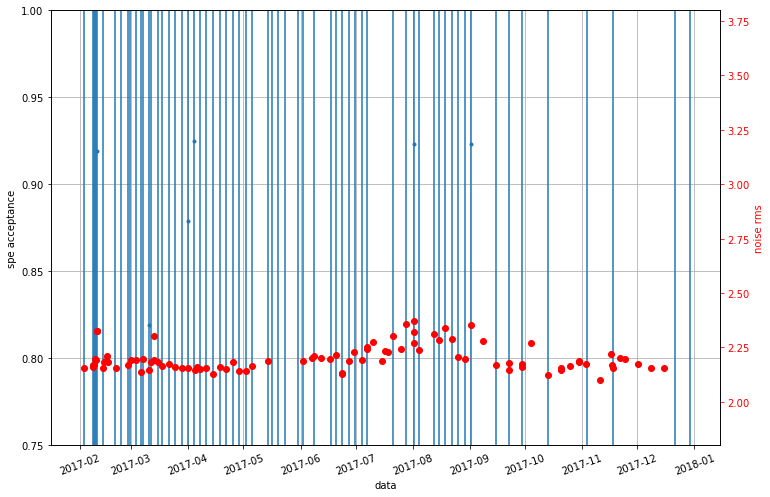

In [ ]:
#plot acceptance vs time 

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%Y-%m')

dates = np.array([get_run_time(run) for run in bottom_runs])
bottom_runs = np.array(bottom_runs)
accs = np.array(accs)
errors = np.array(errors)

noisy_runs = [12768, 13837]

sr1 = np.where(bottom_runs > 6731)
sr1 = [i for i in sr1[0] if bottom_runs[i] not in noisy_runs]

plot_dates = dates[sr1]
plot_runs = bottom_runs[sr1]
plot_accs = accs[sr1]
plot_errors = errors[sr1]

f, ax = plt.subplots(figsize=(12,8))
#plt.errorbar(bottom_runs, accs, yerr=errors, linestyle='None', marker='.')
ax.errorbar(plot_dates, plot_accs, yerr=plot_errors, linestyle='None', marker='.')
ax.set_ylim(0.75, 1.0)
plt.xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=20)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(fmt)
ax.grid()
ax.set_xlabel('data')
ax.set_ylabel('spe acceptance')

ax2 = ax.twinx()
ax2.scatter(noise_dates, noise_rms, color='red')
ax2.tick_params('y', colors='red')
ax2.set_ylabel('noise rms', color='red')
ax2.set_ylim(1.8,3.8)
plt.savefig('new_moneyplot.png')
plt.show()

### Resubmit jobs without all needed data

In [ ]:
#submits jobs that didn't work the first time
for f in resubmit_files:
    submit_job(f)